## Class activation mapping visualization


In [4]:
# Import
import os

import torch
import torch.nn as nn
import torchvision.io
from torchvision.transforms import v2

from torch_api.dataset_utils.dataset_folder_utils import get_loader_from_dir
from torch_api.model_api import get_vgg, get_resnet, get_mobilenet
from utils.params import IMAGENET_MEAN, IMAGENET_STD

In [ ]:
# Dataset
'''
Dataset 1 (few images): https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
Dataset 2 (more than 6000 images): https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
'''
# BRAIN_DS_DIR = os.path.abspath(".\\datasets\\brain_tumor")
BRAIN_DS_DIR = os.path.abspath(".\\datasets\\brain_tumor_2")

TRAIN_DIR = os.path.join(BRAIN_DS_DIR, "train")
VAL_DIR = os.path.join(BRAIN_DS_DIR, "val")
TEST_DIR = os.path.join(BRAIN_DS_DIR, "test")

# Class weight
# CLASS_WEIGHTS = torch.tensor([1, 0.544], dtype=torch.float32) # No class has 0.544 of Yes class
CLASS_WEIGHTS = torch.tensor([1221, 1239, 1495, 1357], dtype=torch.float32)
CLASS_WEIGHTS = CLASS_WEIGHTS.min() / CLASS_WEIGHTS

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Check image's shape
for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    # Loop over classes
    for subdir in os.listdir(TRAIN_DIR):
        sub_path = os.path.join(TRAIN_DIR, subdir)
        # Loop over images in class dir
        for img in os.listdir(sub_path):
            img_path = os.path.join(sub_path, img)
            print(torchvision.io.read_image(img_path).shape)

In [22]:
# Image Classification
H, W = 32, 32
img = torch.randint(0, 256, size=(3, H, W), dtype=torch.uint8)

train_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=False),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),

    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    v2.Grayscale(num_output_channels=3),
    
    # v2.RandomHorizontalFlip(p=0.5),
    # v2.ColorJitter(brightness = [0.9, 1.1]),
])

test_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=False),
    v2.Resize(size=(224, 224), antialias=True),

    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    v2.Grayscale(num_output_channels=3),
])

In [23]:
# Get dataset
train_loader, val_loader, test_loader = get_loader_from_dir(
    base_dir=BRAIN_DS_DIR,
    train_transform=train_transforms,
    test_transform=test_transforms,
    collate_fn=None,
    batch_size=32
)

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Sizes (train/valid/test): 5312 400 1311


In [29]:
# Other stuff
class_to_idx: dict = train_loader.dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

num_classes = len(class_to_idx)

In [ ]:
# Get model
vgg_model = get_vgg(weight_name="default")
resnet_model = get_resnet(weight_name="default")
mobilenet_model = get_mobilenet(weight_name="default")

In [30]:
# Fix the last layers
vgg_model.classifier[-1] = nn.Linear(in_features=4096, out_features=num_classes, bias=True)
resnet_model.fc = nn.Linear(in_features=2048, out_features=num_classes, bias=True)
mobilenet_model.classifier[-1] = nn.Linear(in_features=1024, out_features=num_classes, bias=True)

In [31]:
from torch_api.trainer_api.base import Trainer
from torch_api.regularizer_api import EarlyStopping

# Set things up
optimizer = torch.optim.Adam(resnet_model.parameters(), lr = 0.0005)
criterion = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS).to(DEVICE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 2
) # decrease after 2 times not improving (fluctuate 1 time)
early_stop = EarlyStopping(tolerance = 5)

# Get trainer for VGG
trainer = Trainer(
    model = resnet_model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    optimizer = optimizer,
    criterion = criterion,
    scheduler = scheduler,
    early_stopping = early_stop,
    device = DEVICE,
)

Device of trainer is cuda


In [32]:
# Other blocks False Grad
for child in resnet_model.named_children():
    name, layer = child
    for param in layer.parameters():
        param.requires_grad = False

# Last conv layer
for param in resnet_model.layer4.parameters():
    param.requires_grad = True
for param in resnet_model.fc.parameters():
    param.requires_grad = True

In [33]:
trainer.train(epochs = 10)

--- Epoch 0 Step 50 ; Train Loss 0.3196307122707367 ---
--- Epoch 0 Step 100 ; Train Loss 0.42622894048690796 ---
--- Epoch 0 Step 150 ; Train Loss 0.2080174833536148 ---
EPOCH 0 Train loss: 0.4302604724484754, Val loss: 0.32110116131603716, Val acc: 0.85
--- Epoch 1 Step 50 ; Train Loss 0.5469538569450378 ---
--- Epoch 1 Step 100 ; Train Loss 0.2537703216075897 ---
--- Epoch 1 Step 150 ; Train Loss 0.3359486162662506 ---
EPOCH 1 Train loss: 0.3531355304217123, Val loss: 0.27501777417957785, Val acc: 0.8975
--- Epoch 2 Step 50 ; Train Loss 0.27792593836784363 ---
--- Epoch 2 Step 100 ; Train Loss 0.37315309047698975 ---
--- Epoch 2 Step 150 ; Train Loss 0.1840445101261139 ---
EPOCH 2 Train loss: 0.23351624082908573, Val loss: 0.17559256104752421, Val acc: 0.9375
--- Epoch 3 Step 50 ; Train Loss 0.20627163350582123 ---
--- Epoch 3 Step 100 ; Train Loss 0.10944661498069763 ---
--- Epoch 3 Step 150 ; Train Loss 0.49428844451904297 ---
EPOCH 3 Train loss: 0.20778628847146607, Val loss: 0.2


Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.96      0.97       300
  meningioma       0.94      0.94      0.94       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.98      0.97      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311

Confusion Matrix:
[[288  11   0   1]
 [  7 288   7   4]
 [  0   2 403   0]
 [  1   7   0 292]]
AUC-ROC Score (macro): 0.9981


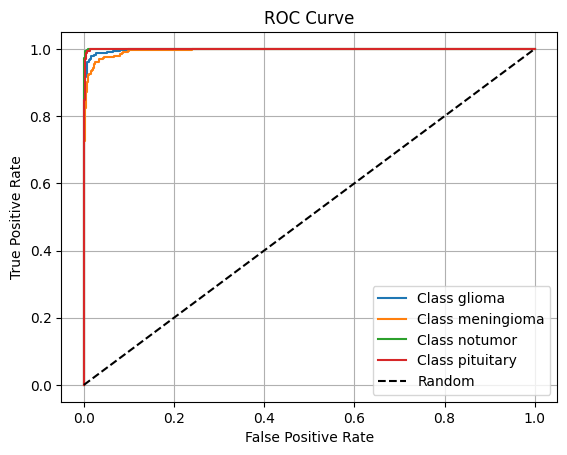

(0.08355998022667921, 96.9488939740656)

In [ ]:
trainer.validate(class_names=list(class_to_idx.keys()),use_val=False)

## Util functions


In [61]:
from typing import Union
import numpy as np
import torch

def set_data_format(t: Union[np.ndarray, torch.Tensor], out_format: str = "torch"):
    if out_format.lower() == "torch":
        return torch.tensor(t)
    elif out_format.lower() == "numpy":
        return np.array(t)
    elif out_format.lower() == "tensorflow":
        raise Exception("Not yet implemented: must be 'torch' or 'numpy'.")
    else:
        raise Exception("Unsupported type.")

def whc_to_chw(t: Union[np.ndarray, torch.Tensor], out_format: str ="torch"):
    # Implementing with different data type 
    if isinstance(t, np.ndarray):
        if len(t.shape) == 4:
            t = t.transpose((0, 3, 2, 1))
        elif len(t.shape) == 3:
            t = t.transpose((2, 1, 0))
        else:
            raise Exception(f"Array t must have shape (batch, width, height, channel) or (width, height, channel). Get {t.shape}")
    elif isinstance(t, torch.Tensor):
        t = t.transpose(-3, -1) # (C, H, W)
    else:
        raise Exception("Not yet implemented: ")
    
    return set_data_format(t, out_format)

def chw_to_whc(t: Union[np.ndarray, torch.Tensor], out_format: str = "numpy"):    
    # Implementing with different data type
    if isinstance(t, np.ndarray):
        if len(t.shape) == 4:
            t = t.transpose((0, 3, 2, 1))
        elif len(t.shape) == 3:
            t = t.transpose((2, 1, 0))
        else:
            raise Exception(f"Array t must have shape (batch, channel, height, width) or (channel, height, width). Get {t.shape}")
    elif isinstance(t, torch.Tensor):
        t = t.transpose(-3, -1) # (C, H, W)
    else:
        raise Exception("Not yet implemented: ")
    t = t.transpose(-3, -1) # (C, H, W)
    return set_data_format(t, out_format)

if __name__ == "__main__":
    data = np.random.randn(24, 32, 3) # (W, H, C)
    torch_tensor = whc_to_chw(data) # (C, H, W)
    numpy_array = chw_to_whc(torch_tensor) # (W, H, C)
    print(data.shape, torch_tensor.shape, numpy_array.shape)

(24, 32, 3) torch.Size([3, 32, 24]) (3, 32, 24)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15384\1872013931.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(t)


In [62]:
data = np.random.randn(1, 24, 32, 3) # (W, H, C)
data_1 = torch.tensor(data) + 2
data_2 = torch.tensor(data) + 3
data_3 = torch.tensor(data) + 4
data_4 = torch.tensor(data) + 5

data_stack = [data_1, data_2, data_3, data_4]
data_stack = [d.squeeze() for d in data_stack]
data_stack_squeezed = [whc_to_chw(d) for d in data_stack]

print(torch.stack(data_stack, dim = 0).shape)
print(torch.stack(data_stack_squeezed, dim = 0).shape)

torch.Size([4, 24, 32, 3])
torch.Size([4, 3, 32, 24])


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15384\1872013931.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t)


## Class Activation Mapping


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def prepare_for_overlay(img: np.ndarray, target_dtype = np.uint8):
    """
    Converts image to a safe dtype for OpenCV addWeighted.
    - If already uint8, returns as-is.
    - If float32/float64 in [0,1], scales to [0,255].
    - Otherwise, casts safely to target_dtype.
    """
    if img.dtype == np.uint8:
        return img
    
    if np.issubdtype(img.dtype, np.floating):
        if img.max() <= 1.0:
            return (img * 255).astype(target_dtype)
        else:
            return img.astype(target_dtype)
    
    return img.astype(target_dtype)

def cam_heatmap_plot(
    original_img: np.ndarray, heatmap: np.ndarray,
):
    # Sanity checking
    if len(heatmap.shape) != 2:
        raise Exception(f"Heatmap must have shape (m, n). Got: {heatmap.shape}")
    
    # Resizing and convert to uint8
    heatmap = cv2.resize(heatmap, dsize = (original_img.shape[1], original_img.shape[0]))
    heatmap = prepare_for_overlay(heatmap, target_dtype=np.uint8)

    original_img = prepare_for_overlay(original_img, target_dtype=np.uint8)

    # Apply color map
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose on original image
    superimposed = cv2.addWeighted(
        original_img,
        alpha = 0.6,
        src2 = heatmap,
        beta = 0.4,
        gamma = 0
    )

    # Plot
    plt.figure(figsize = (6, 3))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM visualization")
    plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
    plt.show()

(224, 224, 3) (224, 224)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15384\3199632585.py:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  plot_img = np.array(plot_img)


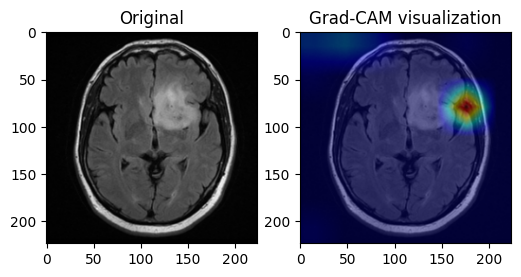

(224, 224, 3) (224, 224)


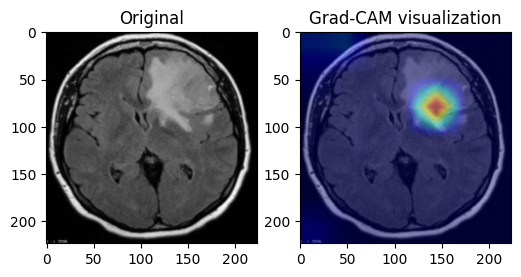

(224, 224, 3) (224, 224)


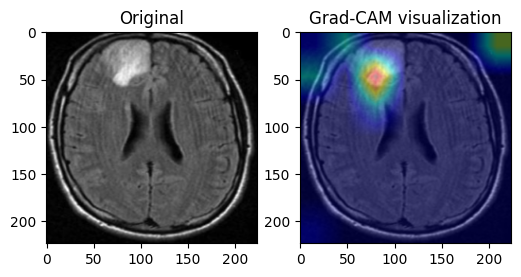

(224, 224, 3) (224, 224)


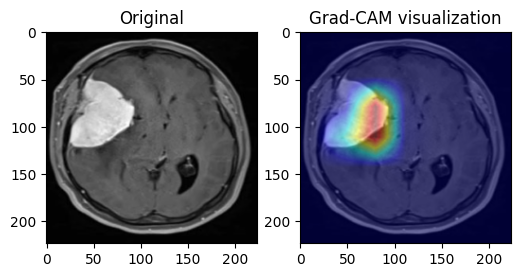

(224, 224, 3) (224, 224)


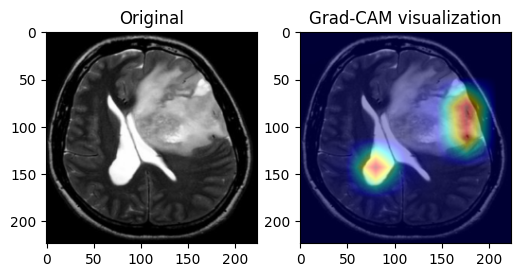

(224, 224, 3) (224, 224)


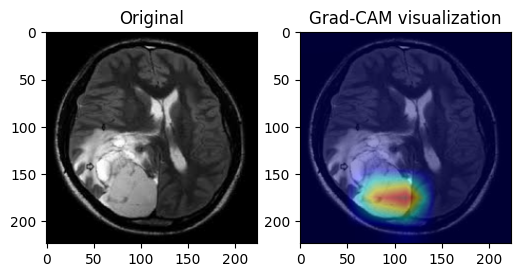

(224, 224, 3) (224, 224)


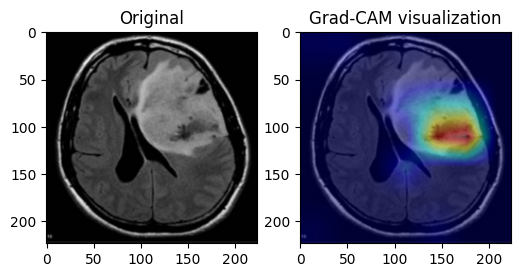

(224, 224, 3) (224, 224)


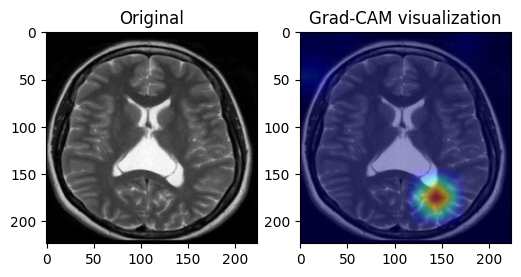

(224, 224, 3) (224, 224)


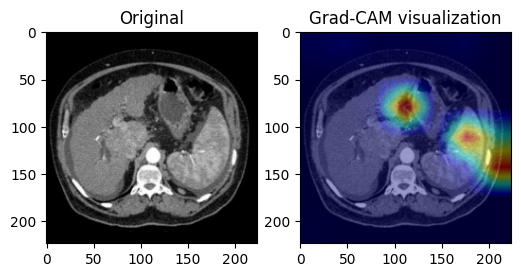

(224, 224, 3) (224, 224)


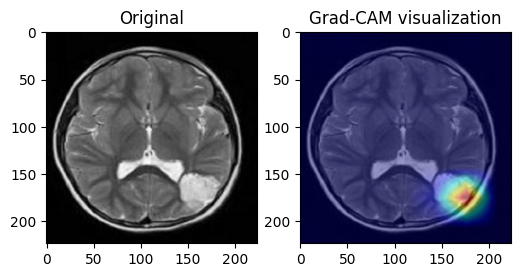

In [ ]:
# Sample code of Pytorch-Grad-CAM
import torch
import torchvision
from torchvision.models import resnet50, ResNet50_Weights
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

from kernels import EdgeDetection, Blur, Sharpen, forward, tensor4plt, normalize_tensor, plot_tensors

resnet_model.eval()
target_layers = [resnet_model.layer4[-1]]

yes_test_dir = ".\\datasets\\brain_tumor\\test\\yes"
no_test_dir = ".\\datasets\\brain_tumor\\test\\no"
chosen_dir = yes_test_dir

# Img paths
img_num = 10
paths = os.listdir(chosen_dir)[:img_num]
paths = [os.path.join(chosen_dir, p) for p in paths]

for i, path in enumerate(paths):
    img = torchvision.io.read_image(path)
    img = img.view(1, img.shape[0], img.shape[1], img.shape[2]).type(torch.float32) # from (C, H, W) to (1, C, H, W)
    img = v2.Resize((224, 224))(img)

    # Shape (224, 224, 4) -> (224, 224, 3) - remove transparency
    if img.shape[1] == 4:
        np_img = img[0].transpose(-3, -1).numpy() # (224, 224, 4)
        np_img = cv2.cvtColor(np_img, cv2.COLOR_RGBA2RGB) # (224, 224, 3)
        img_tensor = torch.tensor(np_img).transpose(-3, -1).reshape(-1, 3, 224, 224) # (3, 224, 224)
    else:
        img_tensor = v2.Grayscale(num_output_channels=3)(img)

    # We have to specify the target we want to generate the CAM for.
    targets = [ClassifierOutputTarget(1)]

    # Construct the CAM object once, and then re-use it on many images.
    with GradCAM(model=resnet_model, target_layers=target_layers) as cam:
        # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
        grayscale_cam = cam(input_tensor = img_tensor, targets = targets)

        # In this example grayscale_cam has only one image in the batch:
        grayscale_cam = grayscale_cam
        grayscale_cam = grayscale_cam[0, :]
        grayscale_cam = cv2.resize(grayscale_cam, (224, 224))
        
        model_outputs = cam.outputs

        import matplotlib.pyplot as plt
        from kernels.utils import tensor4plt

        # Normalize - min max scaling
        plot_img = tensor4plt(img_tensor)
        plot_img = (plot_img - plot_img.min()) / (plot_img.max() - plot_img.min())
        plot_img = np.array(plot_img)

        print(plot_img.shape, grayscale_cam.shape)
        cam_heatmap_plot(plot_img, grayscale_cam)

        # Visualization thru built-in Function of Pytorch-Grad-CAM
        # visualization = show_cam_on_image(plot_img, grayscale_cam, use_rgb=False)
        # print("plot_img shape:", plot_img.shape)
        # print("grayscale_cam shape:", grayscale_cam.shape)
        # print("visualization shape:", visualization.shape)
        # plt.imshow(visualization)
        # plt.show()

In [78]:
# Save model
torch.save(trainer.model, "resnet_model_97_25.pt")

## Kernels visualization


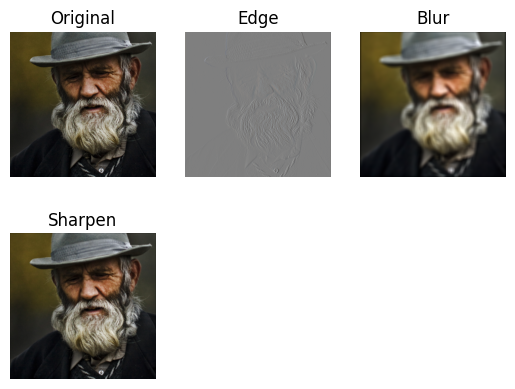

In [9]:
from kernels import EdgeDetection, Blur, Sharpen, forward, tensor4plt, normalize_tensor, plot_tensors

if __name__ == "__main__":
    import torchvision
    import torch

    # Đọc ảnh và chuẩn bị tensor
    path = "my_img.jpg"
    tensor_img = torchvision.io.read_image(path)
    tensor_img = tensor_img.view(1, tensor_img.shape[0], tensor_img.shape[1], tensor_img.shape[2]).type(torch.float32)

    # Áp dụng kernel
    images = [tensor_img,
              forward(tensor_img, EdgeDetection.sobel_x),
              forward(tensor_img, Blur.custom_mean_kernel(25)),
              forward(tensor_img, Sharpen.custom_sharpen(7, 25))]

    # Chuẩn hóa ảnh về khoảng [0, 1]
    for i in range(len(images)):    
        images[i] = normalize_tensor(images[i])

    # Plot ảnh
    plot_tensors(column = 3,
                 Original = images[0], Edge = images[1], Blur = images[2],
                 Sharpen = images[3])